# prédiction multivariée avec le model VAR

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [2]:
df_bdi=pd.read_csv('Baltic Dry Index Historical Data.csv',parse_dates=['Date'],index_col=['Date'])
df_bsi=pd.read_csv('Baltic Supramax Historical Data.csv',parse_dates=['Date'],index_col=['Date'])
df_bpi=pd.read_csv('Baltic Panamax Historical Data.csv',parse_dates=['Date'],index_col=['Date'])
df_bci=pd.read_csv('Baltic Capesize Historical Data.csv',parse_dates=['Date'],index_col=['Date'])
dow_jones_index=pd.read_csv('Simple-X NY Dow Jones Index ETF (1679).csv',parse_dates=['Date'],index_col=['Date'])
china_steel=pd.read_csv('STEEL HRC FOB CHINA Futures Historical Data.csv',parse_dates=['Date'],index_col=['Date'])

In [3]:
features=[df_bdi,df_bsi,df_bpi,df_bci,dow_jones_index,china_steel]
features_names=['df_bdi','df_bsi','df_bpi','df_bci','dow_jones_index','china_steel']

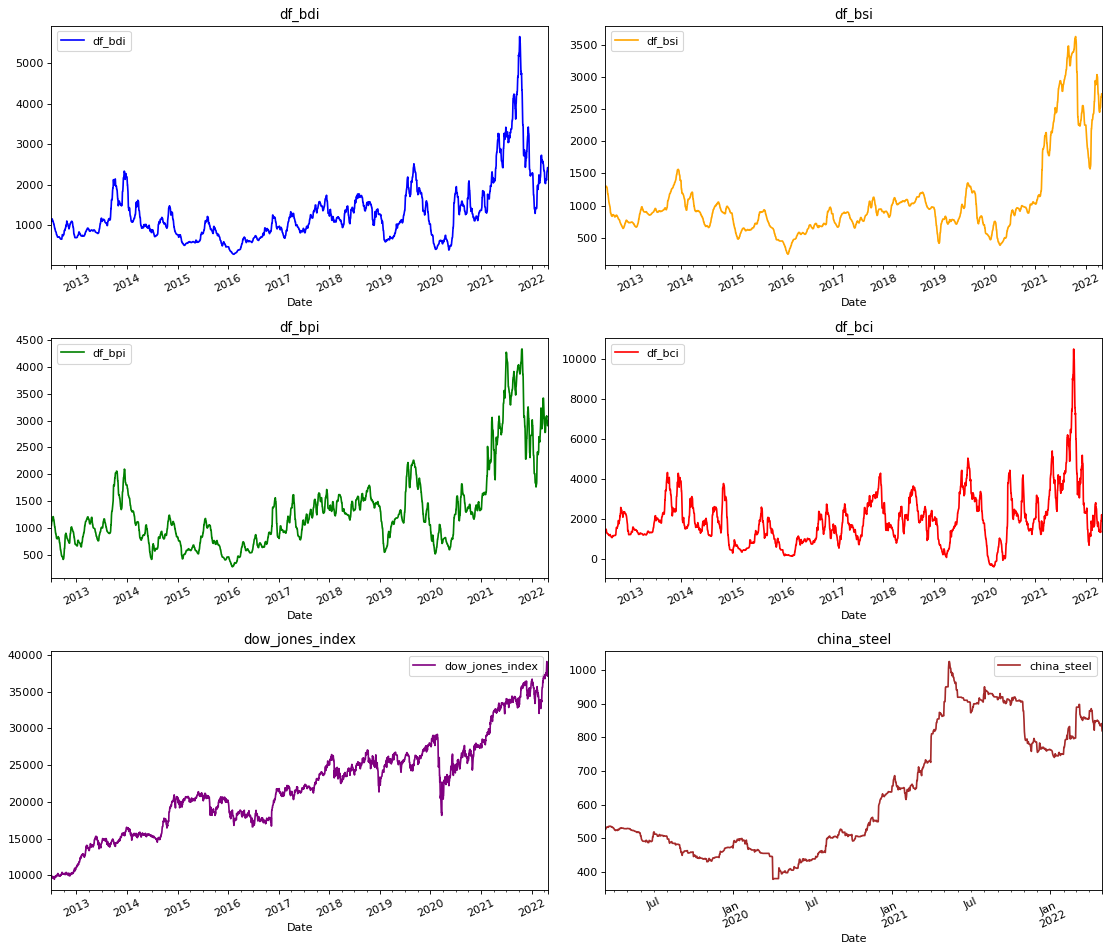

In [4]:
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]
fig, axes = plt.subplots(
        nrows=3, ncols=2, figsize=(14, len(features)*2), dpi=80, facecolor="w", edgecolor="k"
    )
for i in range(len(features)):
    key = features_names[i]
    c = color_list[i % (len(color_list))]
    t_data = features[i]
    #t_data.head()
    ax = t_data.plot(
        ax=axes[i // 2, i % 2],
        color=c,
        title="{}".format(key),
        rot=25,
    )
    ax.legend([key])
plt.tight_layout()

### prédiction du bdi à l'aide du bsi

In [5]:
df_bdi_bsi=pd.concat([df_bdi,df_bsi],axis=1).diff().dropna()

In [6]:
df_bdi_bsi

,BDI,bsi
Date,,
2012-07-05,35.0,9.0
2012-07-06,19.0,3.0
2012-07-07,2.5,1.5
2012-07-08,0.0,0.0
2012-07-09,2.5,1.5
...,...,...
2022-04-26,48.0,15.0
2022-04-27,21.0,22.0
2022-04-28,-22.0,0.0


#### prédiction d'un jour

In [7]:
model = VAR(df_bdi_bsi, freq="1D")

In [8]:
model.select_order(20).summary()


,AIC,BIC,FPE,HQIC
0,12.28,12.28,2.155e+05,12.28
1,10.83,10.84,5.066e+04,10.84
2,10.68,10.70,4.346e+04,10.69
3,10.59,10.61,3.963e+04,10.60
4,10.54,10.58,3.795e+04,10.56
5,10.52,10.55*,3.687e+04,10.53
6,10.51,10.56,3.669e+04,10.53
7,10.51,10.56,3.655e+04,10.52
8,10.50,10.56,3.645e+04,10.52
9,10.50,10.56,3.620e+04,10.52*


In [9]:
p=-30
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(30):
    train=df_bdi_bsi[:p]
    if p==-1:
        test=df_bdi[-1:]
    else:
        test=df_bdi[p:p+1]
    model = VAR(train, freq="1D")
    results = model.fit(5)
    forecasts=results.forecast(train.values[-5:],steps=1) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-1:],index=test.index)
    prédictions.append(f_bdi[-1:])
    values.append(f_bdi[-1:].values.reshape((1,)))
    _list_maes.append(np.mean(np.abs(f_bdi[-1:].values - test.values)))
    _list_rmses.append(np.mean((f_bdi[-1:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-1:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-1:].values - test.values)**2)**.5
    p+=1
maes=maes/30
rmses=rmses/30

In [10]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 09, Jul, 2022
Time:                     10:59:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    10.5473
Nobs:                     3581.00    HQIC:                   10.5228
Log likelihood:          -28957.3    FPE:                    36653.9
AIC:                      10.5093    Det(Omega_mle):         36429.7
--------------------------------------------------------------------
Results for equation BDI
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.075632         0.440364            0.172           0.864
L1.BDI         0.734013         0.017443           42.080           0.000
L1.bsi         0.337920         0.060024            5.630           0.000
L2.BDI        -0

In [11]:
maes,rmses

(22.36582395850906, 22.36582395850906)

In [12]:
values

[array([2355.11623276]),
 array([2354.353538]),
 array([2315.83633003]),
 array([2335.94973909]),
 array([2268.0776083]),
 array([2129.99789381]),
 array([2087.5180449]),
 array([2022.63109289]),
 array([2058.52673992]),
 array([2022.06628088]),
 array([2040.12855403]),
 array([2003.88673875]),
 array([2030.13217779]),
 array([2098.34030931]),
 array([2187.11354226]),
 array([2094.59307733]),
 array([2130.00525968]),
 array([2126.50921125]),
 array([2134.27784227]),
 array([2117.5133603]),
 array([2176.64368757]),
 array([2298.03829534]),
 array([2322.66373883]),
 array([2339.03318868]),
 array([2341.64834379]),
 array([2393.91568579]),
 array([2441.20012258]),
 array([2434.46086186]),
 array([2381.35306157]),
 array([2417.20098502])]

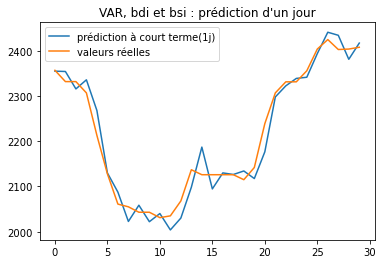

In [13]:
plt.plot(np.array(prédictions).reshape(30,),label='prédiction à court terme(1j)')
plt.plot(df_bdi[-30:].values,label='valeurs réelles')
plt.title("VAR, bdi et bsi : prédiction d'un jour")
plt.legend()

#### prediction d'un mois

In [14]:
p=-300
_10_prédiction=[]
maes=0
_10_maes=[]
rmses=0
_10_rmses=[]
values=[]
for i in range(10):
    train=df_bdi_bsi[:p]
    if p==-30:
        test=df_bdi[-30:]
    else:
        test=df_bdi[p:p+30]
    model = VAR(train, freq="1D")
    results = model.fit(5)
    forecasts=results.forecast(train.values[-5:],steps=30) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test.index)
    _10_prédiction.append(f_bdi[-30:])
    values.append(f_bdi[-30:].values.reshape((30,)))
    _10_maes.append(np.mean(np.abs(f_bdi[-30:].values - test.values)))
    _10_rmses.append(np.mean((f_bdi[-30:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-30:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-30:].values - test.values)**2)**.5
    p+=30
maes=maes/10
rmses=rmses/10
#>> on a testé avec l'ordre 5 et 9 et les meilleurs résultats sont celles avec l'ordre 5

In [15]:
maes,rmses

(412.46327478812935, 502.78241067134786)

In [16]:
values

[array([3256.05518964, 3252.36925865, 3246.08106168, 3241.24873909,
        3238.64233087, 3237.69651734, 3237.75249522, 3237.82874529,
        3237.53571219, 3237.08526682, 3236.87201067, 3237.10555271,
        3237.63128689, 3238.1651068 , 3238.56777257, 3238.89526606,
        3239.27715664, 3239.77444809, 3240.34729976, 3240.92146069,
        3241.45968703, 3241.97752238, 3242.50979241, 3243.07325078,
        3243.65810452, 3244.24491965, 3244.82365927, 3245.39818155,
        3245.97760649, 3246.56646087]),
 array([3289.71784443, 3296.58794033, 3298.38215119, 3299.09791408,
        3301.33866477, 3305.397548  , 3309.83302239, 3313.29199579,
        3315.71577994, 3317.79009705, 3320.10450984, 3322.72358158,
        3325.32118888, 3327.60446891, 3329.54743812, 3331.3197211 ,
        3333.08264056, 3334.86406464, 3336.58981176, 3338.18814857,
        3339.65374545, 3341.03313793, 3342.37197443, 3343.68182951,
        3344.94710457, 3346.15167292, 3347.29599183, 3348.39393984,
        

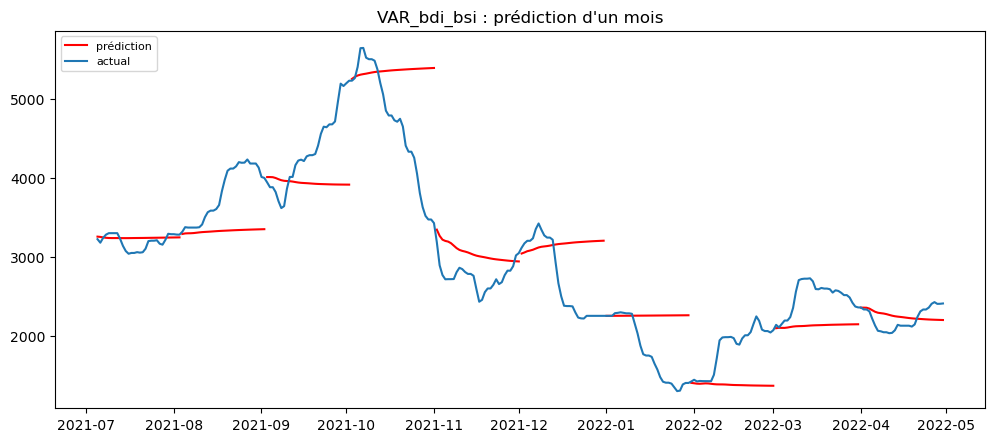

In [17]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(_10_prédiction)):
    if i==0:
        plt.plot(_10_prédiction[i],color='r',label='prédiction')
    else:
        plt.plot(_10_prédiction[i],color='r')
plt.plot(df_bdi[-300:].BDI, label='actual')

plt.title("VAR_bdi_bsi : prédiction d'un mois")
plt.legend(loc='upper left', fontsize=8)
plt.show()

#### prediction d'une semaine

In [18]:
p=-70
_10_prédiction=[]
maes=0
_10_maes=[]
rmses=0
_10_rmses=[]
values=[]
for i in range(10):
    train=df_bdi_bsi[:p]
    if p==-7:
        test=df_bdi[-7:]
    else:
        test=df_bdi[p:p+7]
    model = VAR(train, freq="1D")
    results = model.fit(5)
    forecasts=results.forecast(train.values[-5:],steps=7) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test.index)
    _10_prédiction.append(f_bdi[-7:])
    values.append(f_bdi[-7:].values.reshape((7,)))
    _10_maes.append(np.mean(np.abs(f_bdi[-7:].values - test.values)))
    _10_rmses.append(np.mean((f_bdi[-7:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-7:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-7:].values - test.values)**2)**.5
    p+=7
maes=maes/10
rmses=rmses/10

In [19]:
maes,rmses

(109.28781049876696, 131.4978252561295)

In [20]:
values

[array([2015.39675942, 2031.9358613 , 2050.12885123, 2061.63235134,
        2067.68156901, 2073.60412096, 2082.05101021]),
 array([2077.70544638, 2087.58292402, 2088.00962128, 2083.11878816,
        2077.99591687, 2075.74773089, 2077.40113456]),
 array([2194.75301866, 2187.68874764, 2192.67472292, 2214.67730957,
        2237.83798346, 2250.5395311 , 2254.41302164]),
 array([2760.23269202, 2823.7412278 , 2890.07338615, 2933.76108395,
        2951.15395915, 2957.22346364, 2968.29725545]),
 array([2571.94174787, 2543.347094  , 2526.92699829, 2526.48649165,
        2532.33983792, 2534.6062707 , 2530.24171165]),
 array([2499.68976205, 2504.97134369, 2515.21703441, 2516.99285469,
        2510.38649492, 2502.73378343, 2499.66419562]),
 array([2315.83633003, 2304.21089891, 2283.68791121, 2257.90096732,
        2239.05942893, 2230.26197296, 2225.33057122]),
 array([2022.06628088, 2000.24555791, 1974.45307232, 1947.99336071,
        1929.83633015, 1920.74444441, 1914.5950802 ]),
 array([2130.005

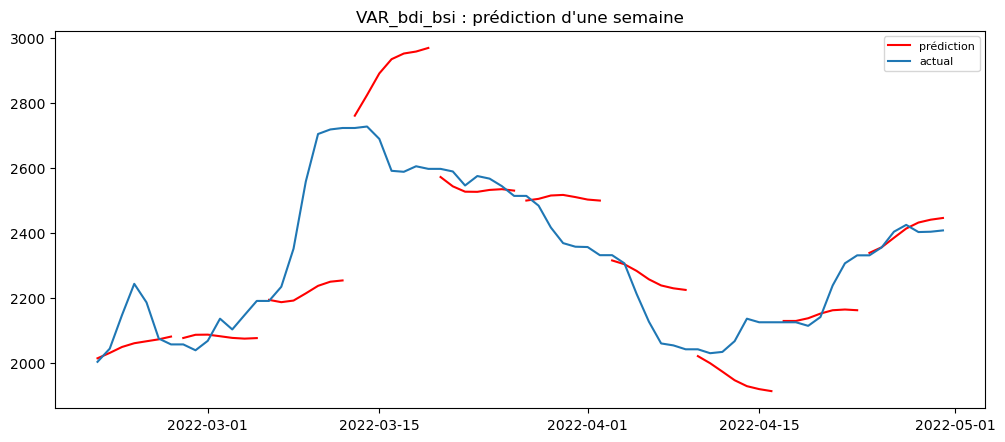

In [21]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(_10_prédiction)):
    if i==0:
        plt.plot(_10_prédiction[i],color='r',label='prédiction')
    else:
        plt.plot(_10_prédiction[i],color='r')
plt.plot(df_bdi[-70:].BDI, label='actual')

plt.title("VAR_bdi_bsi : prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()

### prediction du bdi à l'aide du bci

In [22]:
df_bdi_bci=pd.concat([df_bdi,df_bci],axis=1).diff().dropna()

In [23]:
df_bdi_bci

,BDI,bci
Date,,
2012-07-05,35.0,86.0
2012-07-06,19.0,38.0
2012-07-07,2.5,4.0
2012-07-08,0.0,0.0
2012-07-09,2.5,4.0
...,...,...
2022-04-26,48.0,166.0
2022-04-27,21.0,57.0
2022-04-28,-22.0,-77.0


In [24]:
model = VAR(df_bdi_bci, freq="1D")
model.select_order(20).summary()
#>> on a le minimum de bci avec le lag 5,le minimum de hqic avec le lag 6,39, ensuite on va utiliser le lag 9

,AIC,BIC,FPE,HQIC
0,14.41,14.42,1.819e+06,14.42
1,13.42,13.43,6.702e+05,13.42
2,13.36,13.37,6.322e+05,13.36
3,13.31,13.34,6.041e+05,13.32
4,13.30,13.33,5.991e+05,13.31
5,13.29,13.33*,5.931e+05,13.31
6,13.29,13.33,5.908e+05,13.31*
7,13.29,13.34,5.916e+05,13.31
8,13.29,13.35,5.912e+05,13.31
9,13.29,13.35,5.893e+05,13.31


#### prédiction d'un jour

In [25]:
p=-30
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(30):
    train=df_bdi_bci[:p]
    if p==-1:
        test=df_bdi[-1:]
    else:
        test=df_bdi[p:p+1]
    model = VAR(train, freq="1D")
    results = model.fit(5)
    forecasts=results.forecast(train.values[-5:],steps=1) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-1:],index=test.index)
    prédictions.append(f_bdi[-1:])
    values.append(f_bdi[-1:].values.reshape((1,)))
    _list_maes.append(np.mean(np.abs(f_bdi[-1:].values - test.values)))
    _list_rmses.append(np.mean((f_bdi[-1:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-1:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-1:].values - test.values)**2)**.5
    p+=1
maes=maes/30
rmses=rmses/30

In [26]:
maes,rmses

(23.307683505201204, 23.307683505201204)

In [27]:
values

[array([2352.47769341]),
 array([2351.89889399]),
 array([2309.97850957]),
 array([2336.09878967]),
 array([2273.59223641]),
 array([2139.70520214]),
 array([2086.08522566]),
 array([2019.60616974]),
 array([2062.1863066]),
 array([2017.76221385]),
 array([2038.45737045]),
 array([2010.43965687]),
 array([2045.30562227]),
 array([2094.38177747]),
 array([2179.74412527]),
 array([2094.66650885]),
 array([2140.82782915]),
 array([2128.96623635]),
 array([2133.11612649]),
 array([2111.26629163]),
 array([2168.67644531]),
 array([2297.1181857]),
 array([2328.86345761]),
 array([2345.77790496]),
 array([2339.31480323]),
 array([2383.54855425]),
 array([2433.35876247]),
 array([2433.11321519]),
 array([2388.74194653]),
 array([2417.45011665])]

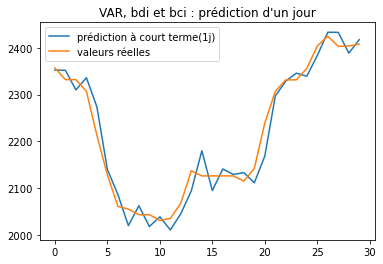

In [28]:
plt.plot(np.array(prédictions).reshape(30,),label='prédiction à court terme(1j)')
plt.plot(df_bdi[-30:].values,label='valeurs réelles')
plt.title("VAR, bdi et bci : prédiction d'un jour")
plt.legend()

#### prediction d'un mois

In [29]:
p=-300
_10_prédiction=[]
maes=0
_10_maes=[]
rmses=0
_10_rmses=[]
values=[]
for i in range(10):
    train=df_bdi_bci[:p]
    if p==-30:
        test=df_bdi[-30:]
    else:
        test=df_bdi[p:p+30]
    model = VAR(train, freq="1D")
    results = model.fit(5)
    forecasts=results.forecast(train.values[-5:],steps=30) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test.index)
    _10_prédiction.append(f_bdi[-30:])
    values.append(f_bdi[-30:].values.reshape((30,)))
    _10_maes.append(np.mean(np.abs(f_bdi[-30:].values - test.values)))
    _10_rmses.append(np.mean((f_bdi[-30:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-30:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-30:].values - test.values)**2)**.5
    p+=30
maes=maes/10
rmses=rmses/10
# ON ATESTé 9,5,6,39 et finallement on choisit l'ordre 6

In [30]:
values

[array([3256.99939113, 3256.35579433, 3253.08529118, 3248.90574933,
        3246.61466969, 3246.36356766, 3247.0039221 , 3247.55862983,
        3247.75255179, 3247.88949624, 3248.25403863, 3248.85511016,
        3249.54120279, 3250.19354639, 3250.80242731, 3251.41192669,
        3252.04949354, 3252.7080044 , 3253.36755354, 3254.0179218 ,
        3254.66146003, 3255.30399201, 3255.9477514 , 3256.59123991,
        3257.23248218, 3257.87104692, 3258.5077111 , 3259.14327896,
        3259.77800156, 3260.41177491]),
 array([3286.98717621, 3290.45964427, 3291.21899195, 3291.35484557,
        3292.55085738, 3294.55146235, 3296.34076745, 3297.61879647,
        3298.59304812, 3299.57666312, 3300.65163962, 3301.71484096,
        3302.6856198 , 3303.56426172, 3304.3948991 , 3305.20950062,
        3306.0100449 , 3306.78725522, 3307.53779848, 3308.26676238,
        3308.98131475, 3309.6855024 , 3310.38027215, 3311.06585658,
        3311.74325181, 3312.41406151, 3313.07972991, 3313.741179  ,
        

In [31]:
maes,rmses

(423.45556162445143, 512.528301355507)

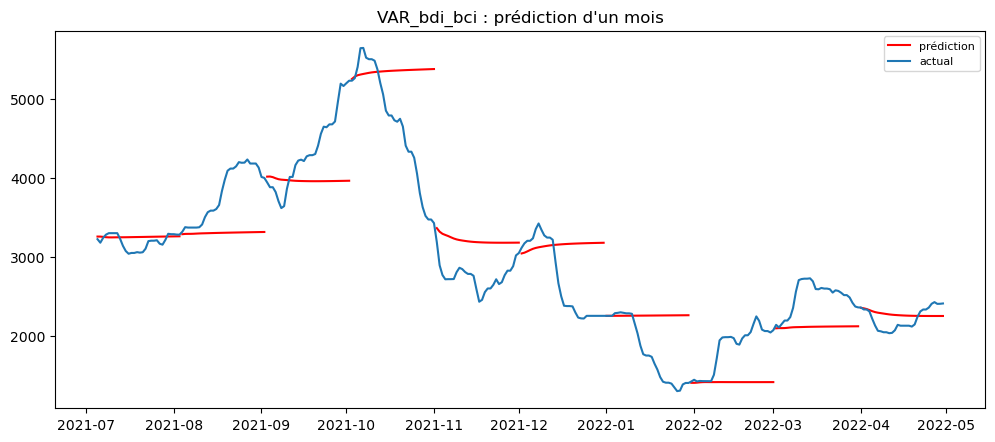

In [32]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(_10_prédiction)):
    if i==0:
        plt.plot(_10_prédiction[i],color='r',label='prédiction')
    else:
        plt.plot(_10_prédiction[i],color='r')
plt.plot(df_bdi[-300:].BDI, label='actual')

plt.title("VAR_bdi_bci : prédiction d'un mois")
plt.legend(loc='best', fontsize=8)
plt.show()

#### prediction d'une semaine

In [33]:
p=-70
_10_prédiction=[]
maes=0
_10_maes=[]
rmses=0
_10_rmses=[]
values=[]
for i in range(10):
    train=df_bdi_bci[:p]
    if p==-7:
        test=df_bdi[-7:]
    else:
        test=df_bdi[p:p+7]
    model = VAR(train, freq="1D")
    results = model.fit(5)
    forecasts=results.forecast(train.values[-5:],steps=7) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test.index)
    _10_prédiction.append(f_bdi[-7:])
    values.append(f_bdi[-7:].values.reshape((7,)))
    _10_maes.append(np.mean(np.abs(f_bdi[-7:].values - test.values)))
    _10_rmses.append(np.mean((f_bdi[-7:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-7:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-7:].values - test.values)**2)**.5
    p+=7
maes=maes/10
rmses=rmses/10
# on a testé 5,6,9,39 et on a choisit l'ordre 5

In [34]:
values

[array([2010.74014324, 2012.25915644, 2016.39861472, 2024.24603335,
        2032.94235368, 2039.39470588, 2043.38787996]),
 array([2082.5140955 , 2099.46480258, 2100.18718483, 2091.52633052,
        2084.75688867, 2084.18369696, 2086.92811766]),
 array([2200.2612412 , 2204.14218785, 2212.68132712, 2226.53942422,
        2240.59417165, 2250.12866218, 2256.0309642 ]),
 array([2759.44005853, 2812.56273003, 2857.50172146, 2881.1850762 ,
        2890.59217379, 2898.6432411 , 2910.3854931 ]),
 array([2577.85619451, 2556.96032214, 2544.88965118, 2542.7382204 ,
        2543.65051946, 2542.64950783, 2539.49044114]),
 array([2498.93311842, 2503.03466696, 2511.09407507, 2513.00712572,
        2509.84538116, 2507.02026681, 2507.25209574]),
 array([2309.97850957, 2293.84301419, 2277.90999228, 2263.37343327,
        2252.3444116 , 2244.27299795, 2237.4648676 ]),
 array([2017.76221385, 1991.88830555, 1969.11604312, 1953.51916445,
        1944.31177314, 1937.11901138, 1929.70483916]),
 array([2140.827

In [35]:
maes,rmses

(105.75286406343454, 125.67612180348092)

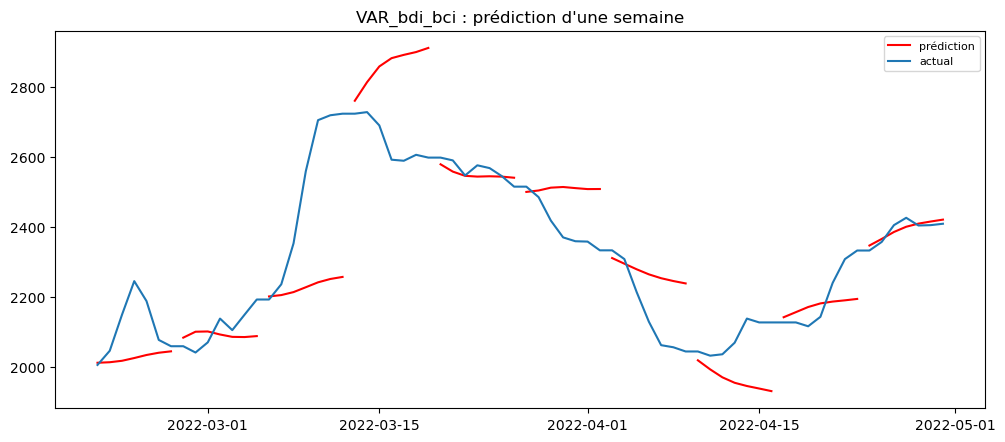

In [36]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(_10_prédiction)):
    if i==0:
        plt.plot(_10_prédiction[i],color='r',label='prédiction')
    else:
        plt.plot(_10_prédiction[i],color='r')
plt.plot(df_bdi[-70:].BDI, label='actual')

plt.title("VAR_bdi_bci : prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()

### prediction du bdi à l'aide du bpi

In [37]:
df_bdi_bpi=pd.concat([df_bdi,df_bpi],axis=1).diff().dropna()

In [38]:
model = VAR(df_bdi_bpi, freq="1D")
model.select_order(20).summary()


,AIC,BIC,FPE,HQIC
0,13.61,13.61,8.127e+05,13.61
1,12.42,12.43,2.467e+05,12.42
2,12.26,12.28,2.107e+05,12.26
3,12.15,12.17*,1.888e+05,12.16
4,12.15,12.18,1.887e+05,12.16
5,12.15,12.19,1.885e+05,12.16
6,12.14,12.18,1.870e+05,12.15
7,12.14,12.19,1.863e+05,12.15
8,12.14,12.19,1.864e+05,12.16
9,12.13,12.20,1.857e+05,12.16


#### prédiction d'un jour

In [39]:
p=-30
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(30):
    train=df_bdi_bpi[:p]
    if p==-1:
        test=df_bdi[-1:]
    else:
        test=df_bdi[p:p+1]
    model = VAR(train, freq="1D")
    results = model.fit(3)
    forecasts=results.forecast(train.values[-3:],steps=1) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-1:],index=test.index)
    prédictions.append(f_bdi[-1:])
    values.append(f_bdi[-1:].values.reshape((1,)))
    _list_maes.append(np.mean(np.abs(f_bdi[-1:].values - test.values)))
    _list_rmses.append(np.mean((f_bdi[-1:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-1:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-1:].values - test.values)**2)**.5
    p+=1
maes=maes/30
rmses=rmses/30

In [40]:
maes,rmses

(23.728136143137355, 23.728136143137355)

In [41]:
values

[array([2348.09774369]),
 array([2350.69642971]),
 array([2315.92162648]),
 array([2340.51112919]),
 array([2275.3002804]),
 array([2146.46922658]),
 array([2083.987373]),
 array([2015.15251773]),
 array([2071.47413853]),
 array([2017.57383493]),
 array([2044.03191027]),
 array([2022.10477162]),
 array([2059.83287682]),
 array([2093.95818556]),
 array([2173.30768477]),
 array([2099.53070545]),
 array([2142.63777482]),
 array([2125.87559912]),
 array([2126.06986339]),
 array([2112.32919521]),
 array([2160.45473757]),
 array([2285.84974376]),
 array([2333.40684601]),
 array([2350.59777779]),
 array([2337.95866962]),
 array([2370.80412656]),
 array([2423.40721072]),
 array([2438.64209842]),
 array([2392.97015956]),
 array([2416.53325582])]

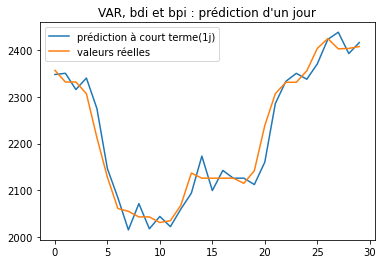

In [42]:
plt.plot(np.array(prédictions).reshape(30,),label='prédiction à court terme(1j)')
plt.plot(df_bdi[-30:].values,label='valeurs réelles')
plt.title("VAR, bdi et bpi : prédiction d'un jour")
plt.legend()

#### prediction d'un mois

In [43]:
p=-300
_10_prédiction=[]
maes=0
_10_maes=[]
rmses=0
_10_rmses=[]
values=[]
for i in range(10):
    train=df_bdi_bpi[:p]
    if p==-30:
        test=df_bdi[-30:]
    else:
        test=df_bdi[p:p+30]
    model = VAR(train, freq="1D")
    results = model.fit(3)
    forecasts=results.forecast(train.values[-3:],steps=30) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test.index)
    _10_prédiction.append(f_bdi[-30:])
    values.append(f_bdi[-30:].values.reshape((30,)))
    _10_maes.append(np.mean(np.abs(f_bdi[-30:].values - test.values)))
    _10_rmses.append(np.mean((f_bdi[-30:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-30:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-30:].values - test.values)**2)**.5
    p+=30
maes=maes/10
rmses=rmses/10


In [44]:
values

[array([3260.63938559, 3263.78517776, 3263.85609266, 3263.39505671,
        3264.22229962, 3265.93088596, 3267.36462414, 3268.25500205,
        3269.01801115, 3269.90447437, 3270.82477627, 3271.65528397,
        3272.40220735, 3273.12521256, 3273.84708843, 3274.55644497,
        3275.24499958, 3275.91836978, 3276.58461995, 3277.24639256,
        3277.90312027, 3278.55500016, 3279.20345417, 3279.8497392 ,
        3280.49436923, 3281.13753354, 3281.77949753, 3282.42058891,
        3283.06105223, 3283.70102415]),
 array([3286.91401199, 3290.86924381, 3291.07788309, 3291.41848345,
        3293.27707453, 3295.31025495, 3296.63009535, 3297.53994664,
        3298.4870274 , 3299.50430304, 3300.44736003, 3301.27467388,
        3302.0423327 , 3302.79503581, 3303.53396949, 3304.24912556,
        3304.94243652, 3305.62284347, 3306.29589784, 3306.96255691,
        3307.62303651, 3308.2786465 , 3308.93096959, 3309.58096044,
        3310.22904458, 3310.87555385, 3311.5208657 , 3312.16530707,
        

In [45]:
maes,rmses

(422.6653034701459, 509.97920035700156)

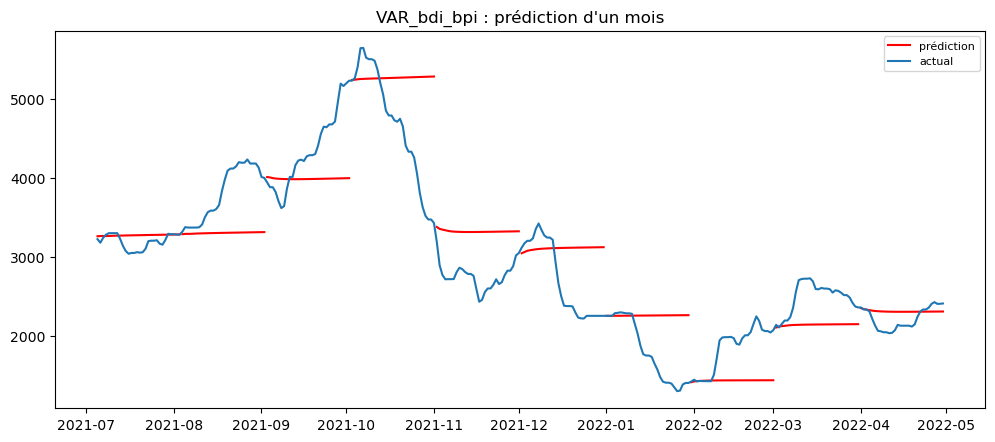

In [46]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(_10_prédiction)):
    if i==0:
        plt.plot(_10_prédiction[i],color='r',label='prédiction')
    else:
        plt.plot(_10_prédiction[i],color='r')
plt.plot(df_bdi[-300:].BDI, label='actual')

plt.title("VAR_bdi_bpi : prédiction d'un mois")
plt.legend(loc='best', fontsize=8)
plt.show()

#### prediction d'une semaine

In [47]:
p=-70
_10_prédiction=[]
maes=0
_10_maes=[]
rmses=0
_10_rmses=[]
values=[]
for i in range(10):
    train=df_bdi_bpi[:p]
    if p==-7:
        test=df_bdi[-7:]
    else:
        test=df_bdi[p:p+7]    
    model = VAR(train, freq="1D")
    results = model.fit(3)
    forecasts=results.forecast(train.values[-3:],steps=7) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test.index)
    _10_prédiction.append(f_bdi[-7:])
    values.append(f_bdi[-7:].values.reshape((7,)))
    _10_maes.append(np.mean(np.abs(f_bdi[-7:].values - test.values)))
    _10_rmses.append(np.mean((f_bdi[-7:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-7:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-7:].values - test.values)**2)**.5
    p+=7
maes=maes/10
rmses=rmses/10

In [48]:
values

[array([2014.06605179, 2022.3564022 , 2031.60385037, 2038.05096095,
        2042.5035292 , 2046.01875901, 2048.54053729]),
 array([2066.32921219, 2058.78958732, 2047.69077815, 2042.63344607,
        2040.45936517, 2038.3697702 , 2036.63381855]),
 array([2201.06593795, 2202.41748669, 2210.50103801, 2219.6838867 ,
        2224.91334365, 2227.5691761 , 2229.87336886]),
 array([2751.48900676, 2779.13612058, 2791.59390068, 2795.53461837,
        2798.86674873, 2802.92175524, 2806.16880254]),
 array([2590.09093666, 2589.33440346, 2588.63651598, 2588.13603451,
        2589.09175712, 2590.38110346, 2591.11681202]),
 array([2498.91536933, 2497.82495587, 2498.33165583, 2495.91007059,
        2493.40036438, 2492.84377262, 2493.42530423]),
 array([2315.92162648, 2309.46361664, 2302.27967373, 2295.21020849,
        2291.23873234, 2289.22523515, 2287.42006018]),
 array([2017.57383493, 1995.71399129, 1984.94778898, 1980.60558391,
        1976.96526414, 1972.90762373, 1969.71857193]),
 array([2142.637

In [49]:
maes,rmses

(102.05960287167072, 123.85291053613)

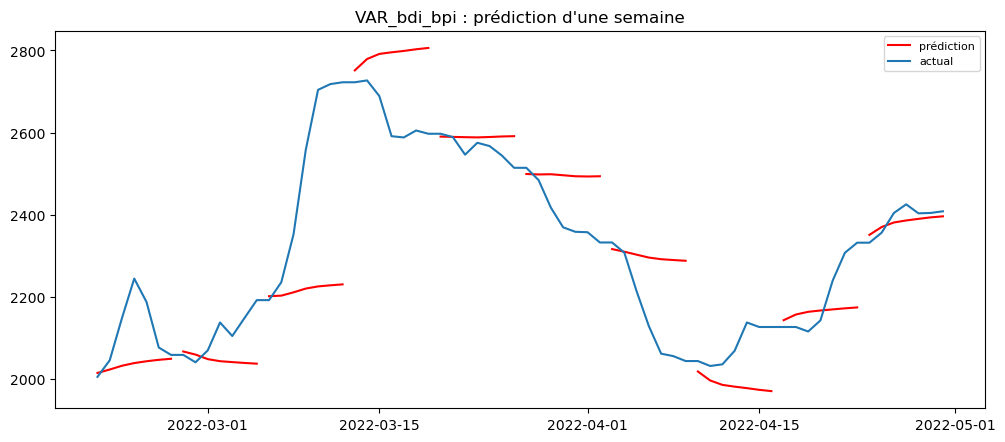

In [50]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(_10_prédiction)):
    if i==0:
        plt.plot(_10_prédiction[i],color='r',label='prédiction')
    else:
        plt.plot(_10_prédiction[i],color='r')
plt.plot(df_bdi[-70:].BDI, label='actual')

plt.title("VAR_bdi_bpi : prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()

### using china_steel

In [51]:
df_bdi_china_steel=pd.concat([df_bdi,china_steel],axis=1).dropna()

In [52]:
df_bdi_china_steel=df_bdi_china_steel.diff().dropna()

In [53]:
df_bdi_china_steel

,BDI,steelHRC
Date,,
2019-03-13,7.0,2.000
2019-03-14,23.0,3.000
2019-03-15,53.0,2.000
2019-03-16,-4.5,-0.250
2019-03-17,0.0,0.000
...,...,...
2022-04-26,48.0,-1.000
2022-04-27,21.0,0.500
2022-04-28,-22.0,4.000


In [54]:
model = VAR(df_bdi_china_steel, freq="1D")
model.select_order(20).summary()


,AIC,BIC,FPE,HQIC
0,11.92,11.93,1.510e+05,11.93
1,11.44,11.47,9.312e+04,11.45
2,11.40,11.44,8.894e+04,11.41
3,11.36,11.42*,8.556e+04,11.38*
4,11.36,11.44,8.587e+04,11.39
5,11.36,11.46,8.565e+04,11.40
6,11.35,11.47,8.523e+04,11.40
7,11.36,11.49,8.548e+04,11.41
8,11.36,11.51,8.574e+04,11.42
9,11.36,11.53,8.553e+04,11.42


#### prédiction d'un jour

In [55]:
p=-30
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(30):
    train=df_bdi_china_steel[:p]
    if p==-1:
        test=df_bdi[-1:]
    else:
        test=df_bdi[p:p+1]
    model = VAR(train, freq="1D")
    results = model.fit(3)
    forecasts=results.forecast(train.values[-3:],steps=1) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-1:],index=test.index)
    prédictions.append(f_bdi[-1:])
    values.append(f_bdi[-1:].values.reshape((1,)))
    _list_maes.append(np.mean(np.abs(f_bdi[-1:].values - test.values)))
    _list_rmses.append(np.mean((f_bdi[-1:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-1:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-1:].values - test.values)**2)**.5
    p+=1
maes=maes/30
rmses=rmses/30

In [56]:
maes,rmses

(23.29957399910618, 23.29957399910618)

In [57]:
values

[array([2354.3350337]),
 array([2358.49724889]),
 array([2309.78817242]),
 array([2345.72871603]),
 array([2282.10245569]),
 array([2150.37944586]),
 array([2088.24282255]),
 array([2021.8329742]),
 array([2050.1225123]),
 array([2019.99348155]),
 array([2042.81518131]),
 array([2014.55994707]),
 array([2038.63086422]),
 array([2097.73896026]),
 array([2175.36697005]),
 array([2105.52691137]),
 array([2142.70498808]),
 array([2124.81532941]),
 array([2126.31254289]),
 array([2107.70254841]),
 array([2166.51110374]),
 array([2305.18028949]),
 array([2330.46514197]),
 array([2343.70208465]),
 array([2336.68048397]),
 array([2377.50793482]),
 array([2433.68290285]),
 array([2428.39752426]),
 array([2388.78069283]),
 array([2417.98169402])]

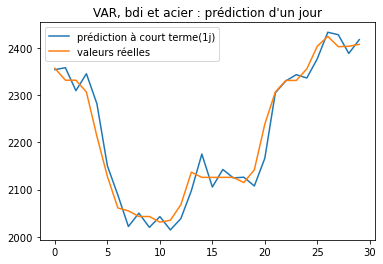

In [58]:
plt.plot(np.array(prédictions).reshape(30,),label='prédiction à court terme(1j)')
plt.plot(df_bdi[-30:].values,label='valeurs réelles')
plt.title("VAR, bdi et acier : prédiction d'un jour")
plt.legend()

#### prédiction de mois

In [59]:
p=-300
_10_prédiction=[]
maes=0
_10_maes=[]
rmses=0
_10_rmses=[]
values=[]
for i in range(10):
    train=df_bdi_china_steel[:p]
    if p==-30:
        test=df_bdi[-30:]
    else:
        test=df_bdi[p:p+30]
    model = VAR(train, freq="1D")
    results = model.fit(3)
    forecasts=results.forecast(train.values[-3:],steps=30) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test.index)
    _10_prédiction.append(f_bdi[-30:])
    values.append(f_bdi[-30:].values.reshape((30,)))
    _10_maes.append(np.mean(np.abs(f_bdi[-30:].values - test.values)))
    _10_rmses.append(np.mean((f_bdi[-30:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-30:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-30:].values - test.values)**2)**.5
    p+=30
maes=maes/10
rmses=rmses/10

In [60]:
maes,rmses

(418.7985565155567, 505.0935777059106)

In [61]:
values

[array([3256.81510502, 3256.11851593, 3256.23756809, 3257.98145712,
        3260.30939736, 3262.74843686, 3265.32399597, 3268.03944394,
        3270.83400557, 3273.66753897, 3276.52649583, 3279.40361954,
        3282.29221299, 3285.18763154, 3288.08732092, 3290.98978131,
        3293.89400265, 3296.79932142, 3299.70532924, 3302.61177421,
        3305.51849588, 3308.42539178, 3311.33239742, 3314.23947239,
        3317.14659113, 3320.05373749, 3322.96090128, 3325.86807606,
        3328.77525779, 3331.68244389]),
 array([3278.90656317, 3277.39805515, 3275.70967802, 3275.55351804,
        3276.6898072 , 3278.39336047, 3280.45377174, 3282.79347129,
        3285.31940244, 3287.95652085, 3290.66166724, 3293.41100763,
        3296.18879516, 3298.98428946, 3301.79079554, 3304.60425561,
        3307.42211408, 3310.24273374, 3313.06508326, 3315.88852004,
        3318.71264111, 3321.5371922 , 3324.3620133 , 3327.18700403,
        3330.01210138, 3332.83726573, 3335.66247217, 3338.48770505,
        

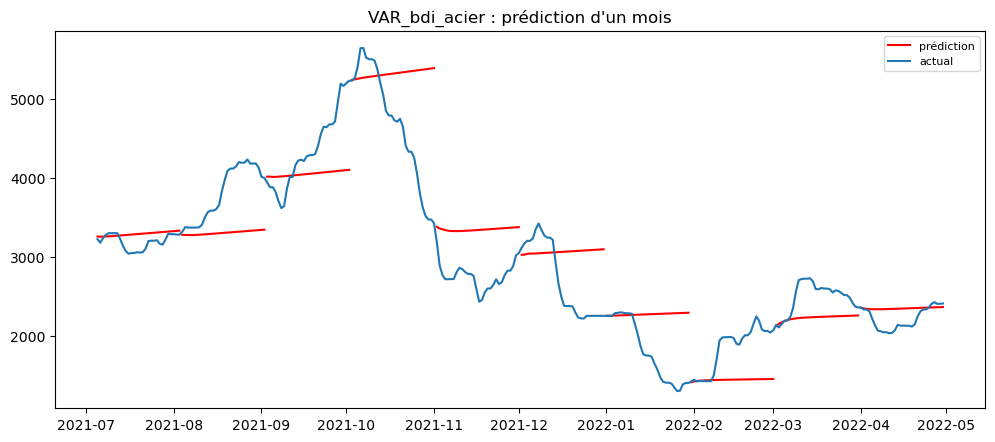

In [62]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(_10_prédiction)):
    if i==0:
        plt.plot(_10_prédiction[i],color='r',label='prédiction')
    else:
        plt.plot(_10_prédiction[i],color='r')
plt.plot(df_bdi[-300:].BDI, label='actual')

plt.title("VAR_bdi_acier : prédiction d'un mois")
plt.legend(loc='best', fontsize=8)
plt.show()

#### prédiction d'une semaine

In [63]:
p=-70
_10_prédiction=[]
maes=0
_10_maes=[]
rmses=0
_10_rmses=[]
values=[]
for i in range(10):
    train=df_bdi_china_steel[:p]
    if p==-7:
        test=df_bdi[-7:]
    else:
        test=df_bdi[p:p+7]
    model = VAR(train, freq="1D")
    results = model.fit(3)
    forecasts=results.forecast(train.values[-3:],steps=7) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test.index)
    _10_prédiction.append(f_bdi[-7:])
    values.append(f_bdi[-7:].values.reshape((7,)))
    _10_maes.append(np.mean(np.abs(f_bdi[-7:].values - test.values)))
    _10_rmses.append(np.mean((f_bdi[-7:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-7:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-7:].values - test.values)**2)**.5
    p+=7
maes=maes/10
rmses=rmses/10

In [64]:
maes,rmses

(99.94073544678518, 121.7432609338754)

In [65]:
values

[array([2008.37848508, 2011.68710571, 2021.43511906, 2029.21582385,
        2032.94361625, 2035.45534734, 2038.05805256]),
 array([2073.59478745, 2071.16526423, 2060.1621433 , 2055.79194267,
        2056.30260178, 2056.53452211, 2056.07063631]),
 array([2203.62118273, 2206.37899112, 2213.1695281 , 2220.38136023,
        2224.63430701, 2227.22416843, 2229.65417229]),
 array([2744.00987464, 2762.23738   , 2769.27184136, 2772.75173623,
        2777.14446518, 2781.35230406, 2784.4220075 ]),
 array([2584.81346831, 2583.04902881, 2585.10690206, 2585.61878162,
        2585.56985259, 2586.35854279, 2587.70449247]),
 array([2496.90797231, 2490.39318565, 2485.80899747, 2481.66086974,
        2479.28476967, 2478.52974163, 2478.5139614 ]),
 array([2309.78817242, 2306.43499184, 2307.59652454, 2306.06534289,
        2304.53107638, 2304.64280816, 2305.50621807]),
 array([2019.99348155, 2000.70726048, 1989.47242231, 1982.76355491,
        1977.63992588, 1973.97119386, 1971.88585103]),
 array([2142.704

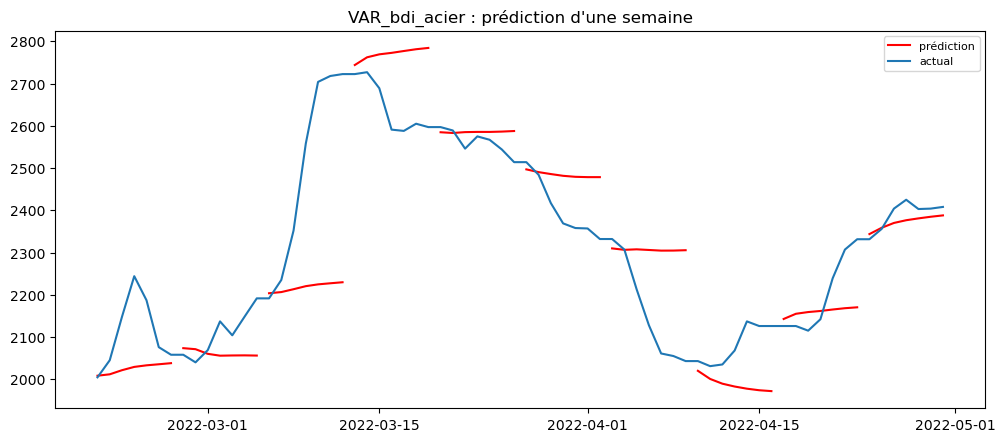

In [66]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(_10_prédiction)):
    if i==0:
        plt.plot(_10_prédiction[i],color='r',label='prédiction')
    else:
        plt.plot(_10_prédiction[i],color='r')
plt.plot(df_bdi[-70:].BDI, label='actual')

plt.title("VAR_bdi_acier : prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()

 vu que le nombre d'enregistrement qu'on du bdi,bsi,bci,bpi est le meme, tandis que celui d'acier est moins, on va tester l'ensemble bsi,bci,bpi et ensuite on va ajouter l'acier

#### à l'aide de dow jones index

In [67]:
df_bdi_dow_jones=pd.concat([df_bdi,dow_jones_index],axis=1)

In [68]:
df_bdi_dow_jones=df_bdi_dow_jones.diff().dropna()

In [69]:
model = VAR(df_bdi_dow_jones, freq="1D")
model.select_order(20).summary()

,AIC,BIC,FPE,HQIC
0,17.96,17.97,6.319e+07,17.96
1,17.48,17.49,3.915e+07,17.49
2,17.44,17.46,3.750e+07,17.45
3,17.40,17.43*,3.618e+07,17.41
4,17.40,17.44,3.619e+07,17.42
5,17.40,17.44,3.602e+07,17.41
6,17.39,17.44,3.585e+07,17.41
7,17.39,17.44,3.571e+07,17.41*
8,17.39,17.45,3.576e+07,17.41
9,17.39,17.45,3.561e+07,17.41


In [70]:
p=-30
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(30):
    train=df_bdi_dow_jones[:p]
    if p==-1:
        test=df_bdi[-1:]
    else:
        test=df_bdi[p:p+1]
    model = VAR(train, freq="1D")
    results = model.fit(3)
    forecasts=results.forecast(train.values[-3:],steps=1) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-1:],index=test.index)
    prédictions.append(f_bdi[-1:])
    values.append(f_bdi[-1:].values.reshape((1,)))
    _list_maes.append(np.mean(np.abs(f_bdi[-1:].values - test.values)))
    _list_rmses.append(np.mean((f_bdi[-1:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-1:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-1:].values - test.values)**2)**.5
    p+=1
maes=maes/30
rmses=rmses/30

In [71]:
maes,rmses

(23.302513582656502, 23.302513582656502)

In [72]:
values

[array([2352.32533067]),
 array([2349.74620454]),
 array([2311.33783705]),
 array([2340.75995319]),
 array([2282.94640361]),
 array([2149.28172043]),
 array([2088.67128429]),
 array([2018.30784996]),
 array([2059.34803164]),
 array([2023.67065353]),
 array([2045.58761792]),
 array([2019.97844897]),
 array([2041.02601501]),
 array([2092.20194007]),
 array([2180.65165517]),
 array([2099.07103646]),
 array([2143.59753473]),
 array([2123.97028794]),
 array([2126.57814802]),
 array([2109.4653729]),
 array([2169.62382198]),
 array([2304.25878243]),
 array([2328.77290602]),
 array([2341.84550054]),
 array([2336.96958527]),
 array([2376.50405914]),
 array([2436.5350123]),
 array([2426.2192791]),
 array([2392.87610071]),
 array([2414.6670901])]

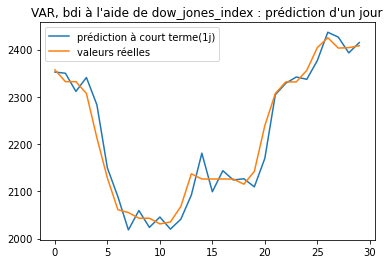

In [73]:
plt.plot(np.array(prédictions).reshape(30,),label='prédiction à court terme(1j)')
plt.plot(df_bdi[-30:].values,label='valeurs réelles')
plt.title("VAR, bdi à l'aide de dow_jones_index : prédiction d'un jour")
plt.legend()

#### prédicton d'un mois

In [74]:
p=-300
_10_prédiction=[]
maes=0
_10_maes=[]
rmses=0
_10_rmses=[]
values=[]
for i in range(10):
    train=df_bdi_dow_jones[:p]
    if p==-30:
        test=df_bdi.BDI[-30:]
    else:
        test=df_bdi.BDI[p:p+30]
    model = VAR(train, freq="1D")
    results = model.fit(3)
    forecasts=results.forecast(train.values[-3:],steps=30) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test.index)
    _10_prédiction.append(f_bdi[-30:])
    values.append(f_bdi[-30:].values.reshape((30,)))
    _10_maes.append(np.mean(np.abs(f_bdi[-30:].values - test.values.reshape(30,1))))
    _10_rmses.append(np.mean((f_bdi[-30:].values - test.values.reshape(30,1))**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-30:].values - test.values.reshape(30,1)))
    rmses=rmses+np.mean((f_bdi[-30:].values - test.values.reshape(30,1))**2)**.5
    p+=30
maes=maes/10
rmses=rmses/10

In [75]:
maes,rmses

(426.2045787450664, 512.483202793681)

In [76]:
values

[array([3255.05074523, 3251.28258353, 3248.63181019, 3248.03545481,
        3248.01130426, 3248.01597282, 3248.18751493, 3248.5563091 ,
        3249.02839067, 3249.5472116 , 3250.10114135, 3250.68317703,
        3251.28309892, 3251.89363969, 3252.51122027, 3253.13369117,
        3253.7593866 , 3254.38714713, 3255.01626097, 3255.64627743,
        3256.27688989, 3256.90789197, 3257.53914978, 3258.17057638,
        3258.80211422, 3259.43372515, 3260.06538413, 3260.69707475,
        3261.32878619, 3261.96051134]),
 array([3280.18106843, 3279.20873822, 3278.92824503, 3279.07454589,
        3279.3697813 , 3279.7562358 , 3280.23038285, 3280.76634357,
        3281.33680187, 3281.92846509, 3282.53525812, 3283.1523619 ,
        3283.77597391, 3284.40374118, 3285.0342765 , 3285.66665218,
        3286.30022493, 3286.934575  , 3287.56943553, 3288.20463198,
        3288.84004828, 3289.47560818, 3290.11126217, 3290.74697785,
        3291.38273395, 3292.01851649, 3292.65431636, 3293.29012758,
        

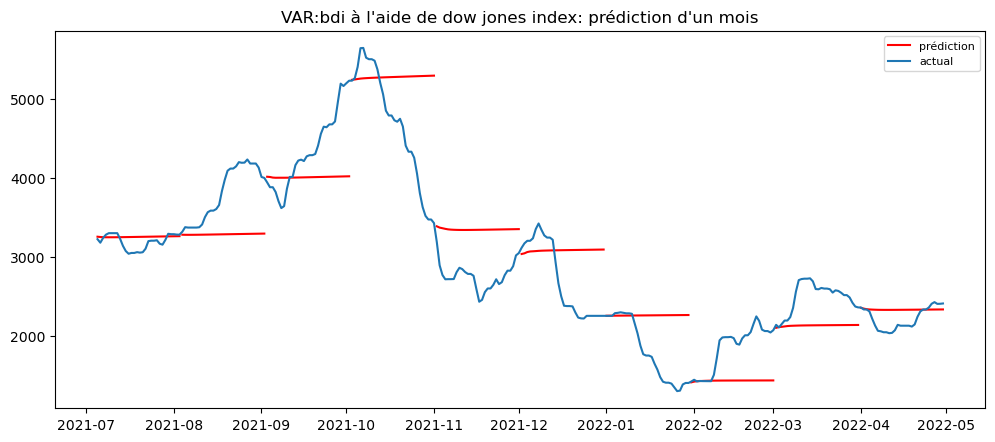

In [77]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(_10_prédiction)):
    if i==0:
        plt.plot(_10_prédiction[i],color='r',label='prédiction')
    else:
        plt.plot(_10_prédiction[i],color='r')
plt.plot(df_bdi[-300:].BDI, label='actual')


plt.title("VAR:bdi à l'aide de dow jones index: prédiction d'un mois")
plt.legend(loc='best', fontsize=8)
plt.show()

#### prédiction d'une semaine

In [78]:
p=-70
_10_prédiction=[]
maes=0
_10_maes=[]
rmses=0
_10_rmses=[]
values=[]
for i in range(10):
    train=df_bdi_dow_jones[:p]
    if p==-7:
        test=df_bdi.BDI[-7:]
    else:
        test=df_bdi.BDI[p:p+7]
    model = VAR(train, freq="1D")
    results = model.fit(3)
    forecasts=results.forecast(train.values[-3:],steps=7) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test.index)
    _10_prédiction.append(f_bdi[-7:])
    values.append(f_bdi[-7:].values.reshape((7,)))
    _10_maes.append(np.mean(np.abs(f_bdi[-7:].values - test.values.reshape(7,1))))
    _10_rmses.append(np.mean((f_bdi[-7:].values - test.values.reshape(7,1))**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-7:].values - test.values.reshape(7,1)))
    rmses=rmses+np.mean((f_bdi[-7:].values - test.values.reshape(7,1))**2)**.5
    p+=7
maes=maes/10
rmses=rmses/10

In [79]:
maes,rmses

(99.02384829035773, 120.6720300065524)

In [80]:
values

[array([2006.94907854, 2010.02004236, 2019.49517978, 2026.43246677,
        2029.30179639, 2031.05007656, 2032.83851705]),
 array([2072.89213811, 2068.84497515, 2057.09211071, 2052.17826378,
        2051.73886239, 2050.94978771, 2049.62425984]),
 array([2202.78701486, 2205.42265154, 2212.06766511, 2218.63006286,
        2222.09572572, 2223.91960114, 2225.51680995]),
 array([2749.34931352, 2771.75985346, 2780.98974774, 2785.74759047,
        2790.76083607, 2794.99849428, 2797.66890647]),
 array([2584.81302512, 2581.20722744, 2581.11564603, 2580.10759716,
        2578.78305622, 2578.21947593, 2578.19252195]),
 array([2498.12241131, 2491.35943186, 2485.85002544, 2480.97282699,
        2477.8832386 , 2476.2339868 , 2475.21543128]),
 array([2311.33783705, 2303.88730327, 2300.50104689, 2296.6025114 ,
        2293.40266668, 2291.71454465, 2290.87229294]),
 array([2023.67065353, 2011.16782447, 2005.79236552, 2002.29709314,
        1999.09097303, 1996.83977804, 1995.60108641]),
 array([2143.597

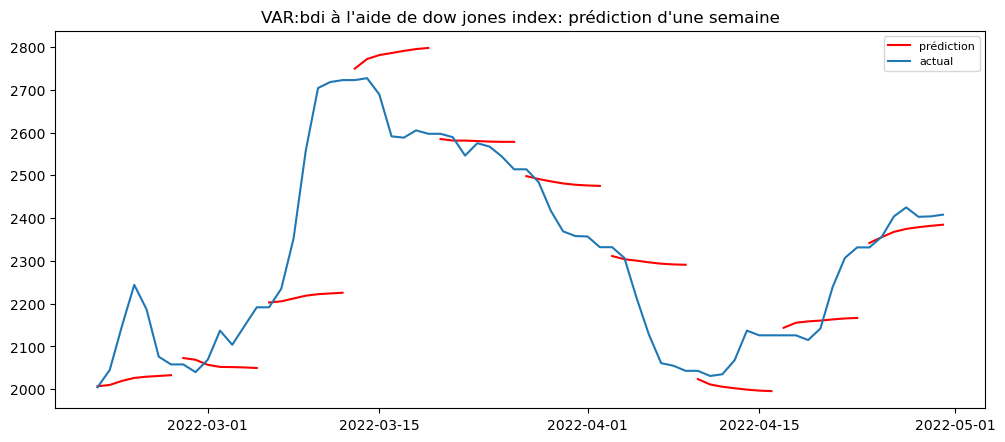

In [81]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(_10_prédiction)):
    if i==0:
        plt.plot(_10_prédiction[i],color='r',label='prédiction')
    else:
        plt.plot(_10_prédiction[i],color='r')
plt.plot(df_bdi[-70:].BDI, label='actual')

plt.title("VAR:bdi à l'aide de dow jones index: prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()

### à l'aide de bsi,bpi,bci,steel,et dow jones index

In [82]:
df_multivar4=pd.concat([df_bdi,df_bci,df_bpi,df_bsi,dow_jones_index,china_steel],axis=1).dropna()

In [83]:
diff_multivar4=df_multivar4.diff().dropna()

In [84]:
model = VAR(diff_multivar4, freq="1D")
model.select_order(20).summary()


,AIC,BIC,FPE,HQIC
0,42.78,42.81,3.810e+18,42.79
1,40.56,40.75,4.130e+17,40.63
2,40.26,40.61*,3.062e+17,40.39
3,40.11,40.62,2.626e+17,40.30*
4,40.10,40.77,2.609e+17,40.36
5,40.10,40.93,2.595e+17,40.41
6,40.10,41.09,2.592e+17,40.47
7,40.09*,41.25,2.587e+17*,40.53
8,40.12,41.44,2.660e+17,40.62
9,40.15,41.63,2.742e+17,40.71


#### prédiction d'un jour

In [85]:
p=-30
prédictions=[]
maes=0
_list_maes=[]
rmses=0
_list_rmses=[]
values=[]
for i in range(30):
    train=diff_multivar4[:p]
    if p==-1:
        test=df_bdi[-1:]
    else:
        test=df_bdi[p:p+1]
    model = VAR(train, freq="1D")
    results = model.fit(2)
    forecasts=results.forecast(train.values[-2:],steps=1) 
    x, x_diff = df_bdi['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-1:],index=test.index)
    prédictions.append(f_bdi[-1:])
    values.append(f_bdi[-1:].values.reshape((1,)))
    _list_maes.append(np.mean(np.abs(f_bdi[-1:].values - test.values)))
    _list_rmses.append(np.mean((f_bdi[-1:].values - test.values)**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-1:].values - test.values))
    rmses=rmses+np.mean((f_bdi[-1:].values - test.values)**2)**.5
    p+=1
maes=maes/30
rmses=rmses/30

In [86]:
maes,rmses

(20.85123390782904, 20.85123390782904)

In [87]:
values

[array([2347.20823469]),
 array([2358.69463471]),
 array([2319.36529118]),
 array([2343.57610734]),
 array([2280.57234713]),
 array([2137.69713011]),
 array([2073.45134048]),
 array([2018.39193699]),
 array([2067.39594974]),
 array([2039.93783857]),
 array([2047.92475183]),
 array([2018.14419619]),
 array([2043.06650565]),
 array([2111.50586982]),
 array([2178.41640862]),
 array([2101.44211293]),
 array([2122.78455039]),
 array([2126.36021973]),
 array([2126.95026888]),
 array([2121.93192611]),
 array([2176.95453226]),
 array([2302.18337214]),
 array([2334.543606]),
 array([2332.11141747]),
 array([2329.12034636]),
 array([2366.50210556]),
 array([2433.22483195]),
 array([2436.54604602]),
 array([2392.56913498]),
 array([2409.17991106])]

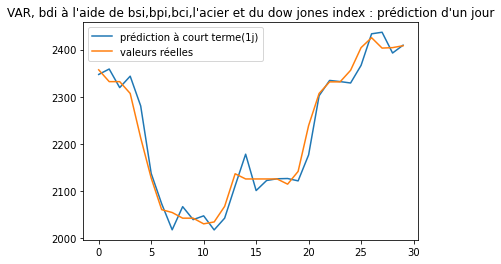

In [88]:
plt.plot(np.array(prédictions).reshape(30,),label='prédiction à court terme(1j)')
plt.plot(df_bdi[-30:].values,label='valeurs réelles')
plt.title("VAR, bdi à l'aide de bsi,bpi,bci,l'acier et du dow jones index : prédiction d'un jour")
plt.legend()

#### mois

In [89]:
p=-300
_10_prédiction=[]
maes=0
_10_maes=[]
rmses=0
_10_rmses=[]
values=[]
for i in range(10):
    train=diff_multivar4[:p]
    if p==-30:
        test=df_multivar4.BDI[-30:]
    else:
        test=df_multivar4.BDI[p:p+30]
    model = VAR(train, freq="1D")
    results = model.fit(2)
    forecasts=results.forecast(train.values[-2:],steps=30) 
    x, x_diff = df_multivar4['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-30:],index=test.index)
    _10_prédiction.append(f_bdi[-30:])
    values.append(f_bdi[-30:].values.reshape((30,)))
    _10_maes.append(np.mean(np.abs(f_bdi[-30:].values - test.values.reshape(30,1))))
    _10_rmses.append(np.mean((f_bdi[-30:].values - test.values.reshape(30,1))**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-30:].values - test.values.reshape(30,1)))
    rmses=rmses+np.mean((f_bdi[-30:].values - test.values.reshape(30,1))**2)**.5
    p+=30
maes=maes/10
rmses=rmses/10

In [90]:
maes,rmses

(429.52372306108964, 517.0567458103807)

In [91]:
values

[array([3261.02515807, 3267.12866614, 3271.82543383, 3275.50035234,
        3278.67942209, 3281.68682429, 3284.67435541, 3287.68524926,
        3290.71810386, 3293.76090141, 3296.80498517, 3299.84702246,
        3302.88698934, 3305.9259251 , 3308.96471516, 3312.00376778,
        3315.04313146, 3318.08270124, 3321.12235997, 3324.16203357,
        3327.20169236, 3330.2413332 , 3333.28096262, 3336.32058745,
        3339.36021164, 3342.39983662, 3345.43946241, 3348.47908862,
        3351.51871493, 3354.5583412 ]),
 array([3281.68172872, 3283.3914039 , 3285.71640013, 3288.13309593,
        3290.81855922, 3293.57975885, 3296.42648454, 3299.30955932,
        3302.2178486 , 3305.14023604, 3308.07324151, 3311.01388773,
        3313.95985944, 3316.90898823, 3319.85963764, 3322.81076401,
        3325.76185237, 3328.71273457, 3331.66341857, 3334.61396957,
        3337.56445034, 3340.51490206, 3343.46534557, 3346.41578885,
        3349.36623371, 3352.31667986, 3355.26712671, 3358.21757388,
        

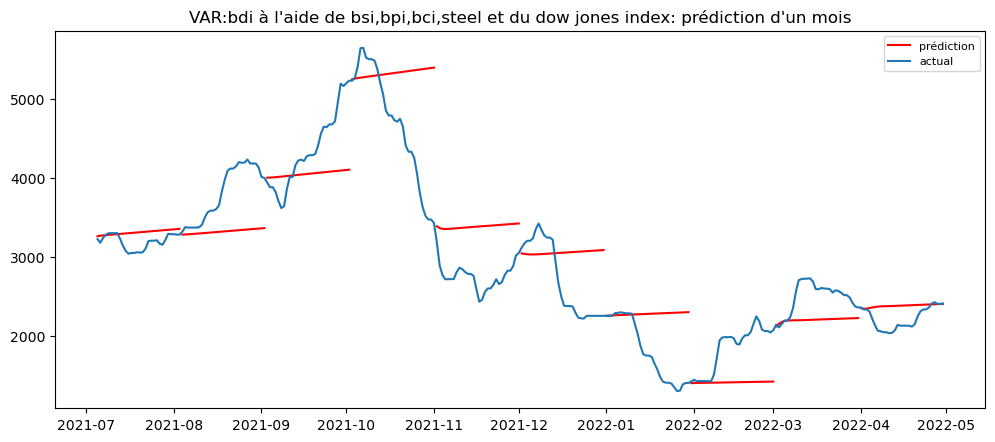

In [92]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(_10_prédiction)):
    if i==0:
        plt.plot(_10_prédiction[i],color='r',label='prédiction')
    else:
        plt.plot(_10_prédiction[i],color='r')
plt.plot(df_multivar4[-300:].BDI, label='actual')


plt.title("VAR:bdi à l'aide de bsi,bpi,bci,steel et du dow jones index: prédiction d'un mois")
plt.legend(loc='best', fontsize=8)
plt.show()

#### semaine

In [93]:
p=-70
_10_prédiction=[]
maes=0
_10_maes=[]
rmses=0
_10_rmses=[]
values=[]
for i in range(10):
    train=diff_multivar4[:p]
    if p==-7:
        test=df_multivar4.BDI[-7:]
    else:
        test=df_multivar4.BDI[p:p+7]
    model = VAR(train, freq="1D")
    results = model.fit(2)
    forecasts=results.forecast(train.values[-2:],steps=7) 
    x, x_diff = df_multivar4['BDI'].iloc[p-1], forecasts[:,0]
    f_bdi = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float)[-7:],index=test.index)
    _10_prédiction.append(f_bdi[-7:])
    values.append(f_bdi[-7:].values.reshape((7,)))
    _10_maes.append(np.mean (np.abs(f_bdi[-7:].values - test.values.reshape(7,1))))
    _10_rmses.append(np.mean((f_bdi[-7:].values - test.values.reshape(7,1))**2)**.5)
    maes=maes+np.mean(np.abs(f_bdi[-7:].values - test.values.reshape(7,1)))
    rmses=rmses+np.mean((f_bdi[-7:].values - test.values.reshape(7,1))**2)**.5
    p+=7
maes=maes/10
rmses=rmses/10

In [94]:
maes,rmses

(98.2971935444198, 122.24131603695942)

In [95]:
values

[array([2022.76154651, 2029.64780087, 2031.67419806, 2031.73205817,
        2031.38508749, 2031.30021923, 2031.6782354 ]),
 array([2072.19268832, 2088.73013633, 2100.69321892, 2107.74759981,
        2111.59128368, 2113.68782488, 2115.00193425]),
 array([2208.56629181, 2206.64476806, 2198.27814316, 2190.96823575,
        2187.02809017, 2186.04572832, 2186.85460676]),
 array([2719.75854162, 2717.85134963, 2718.40315579, 2721.05344829,
        2724.51372108, 2727.8420708 , 2730.64967746]),
 array([2592.87764183, 2592.25880243, 2591.12969644, 2589.34283616,
        2587.83293924, 2587.30021201, 2587.82994772]),
 array([2492.33064805, 2480.00324573, 2474.71942634, 2473.86152861,
        2475.30449219, 2477.64175793, 2480.09313163]),
 array([2319.36529118, 2324.54095207, 2335.54789816, 2345.1533881 ,
        2351.07986132, 2353.98156607, 2355.23379088]),
 array([2039.93783857, 2041.73928593, 2044.01109439, 2045.70346754,
        2046.95934892, 2048.09096915, 2049.24945812]),
 array([2122.784

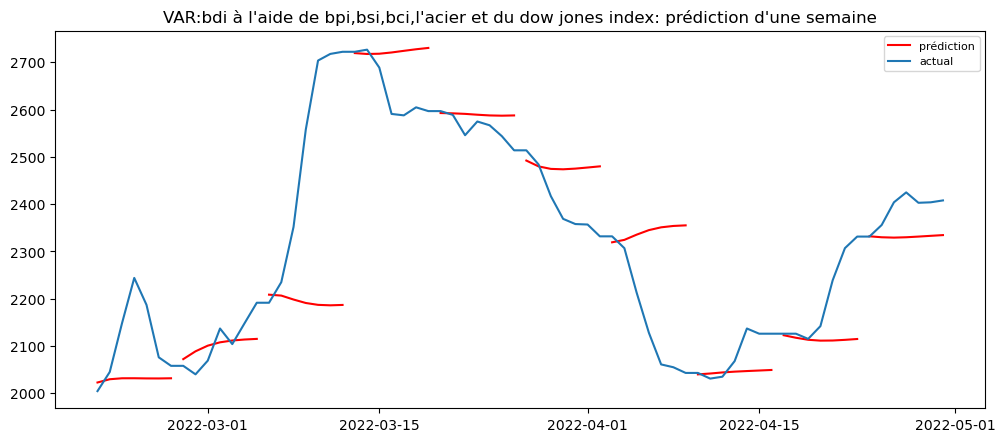

In [96]:
plt.figure(figsize=(12,5), dpi=100)
for i in range(len(_10_prédiction)):
    if i==0:
        plt.plot(_10_prédiction[i],color='r',label='prédiction')
    else:
        plt.plot(_10_prédiction[i],color='r')
plt.plot(df_multivar4[-70:].BDI, label='actual')

plt.title("VAR:bdi à l'aide de bpi,bsi,bci,l'acier et du dow jones index: prédiction d'une semaine")
plt.legend(loc='best', fontsize=8)
plt.show()